# Initial condition optimization
When optimizing the initial conditions of a dynamical system, computing gradients naively can be very expensive. Consider an $N$-body gravitational simulation: the system's state evolves according to Newton's laws, and a loss function $L$ depends on the state at a final time $T$. To adjust initial positions and velocities to minimize $L$, we need $\nabla L$ with respect to those initial conditions.

### Option 1: Backpropagation
We could simulate forward, store every intermediate state, and then apply discrete backpropagation. However, storing an entire trajectory (with many time steps) uses huge memory. For long simulations, this is infeasible.

### Option 2: Adjoint method
Instead of storing the trajectory, the adjoint method derives **co-state variables** (Lagrange multipliers) that can be integrated backward in time to compute gradients. This uses far less memory because we don't keep every intermediate state – we can recompute or integrate on the fly. I.e., the adjoint method tracks how the final loss $L(x(T))$ “flows backward” through the dynamics to influence initial conditions.

# The ODE
Consider a system governed by a second-order ODE (gravity). Let $x(t)\in \mathbb{R}^d$ and $p(t)\in \mathbb{R}^d$ be the generalized coordinates and the conjugate momenta. The equations of motion (EOMs) are, for $t\in[0,T]$:
$$
\begin{align}
\dot{x}(t) &= p(t) \\ 
\dot{p}(t) &= f\!\big(x(t)\big) \\
f(x(t)) &= \text{force field}
\end{align}
$$

**Initial conditions:** $x(0) = x_0$ and $p(0) = p_0$. 

**Terminal loss:** We define a loss function that depends on the state at final time $T$, $L\big(x(T)\big)$, which we aim to minimize by choosing appropriate $x_0, p_0$. The dependence on initial conditions is implicit, mediated by the ODE: $L = L(x(T(x_0, p_0)))$.

Our goal is to derive an expression for the gradient $\displaystyle \frac{\partial L}{\partial x_0}$ and $\displaystyle \frac{\partial L}{\partial p_0}$ using the adjoint method.





# The adjoint method

Want to find how a loss function $L=\mathcal{L}(x(T))$, typically defined at the final time (e.g., comparing simulated and observed matter distribution), depends on initial parameters (e.g., initial positions/velocities or cosmological parameters). i.e., **want to compute how a final loss $\mathcal{L}(x(T))$ depends on the initial condition $x(0)$, for an ODE**:
$$\frac{dx}{dt} = f(x(t), t), \quad x(0) = x_0$$

## Setup the augmented Lagrangian
We want to minimize the loss $\mathcal{L}(x(T))$ subject to the ODE. This is **optimization with a constraint**: the system must obey the ODE. So we introduce time-dependent **Lagrange multipliers (adjoint variables)**. These adjoint variables will enforce that $x(t)$ and $p(t)$ follow the ODE while we vary the initial conditions.


**Simple Lagrange multiplier:**
> Example: $$\text{minimize } f(x) \text{ subject to } g(x) = 0$$
> 
> Lagrangian: $$\mathcal{L} = f(x) + \lambda g(x)$$
> 
> Stationarity: $$\partial_x \mathcal{L} = 0 \quad \red{\text{optimizing $x$}}, \quad \partial_\lambda \mathcal{L} = 0 \quad \red{\text{constraint}}$$


Let 

$\lambda_x(t)\in \mathbb{R}^d$ correspond to the constraint $\dot{x} - p = 0$, and 

$\lambda_p(t)\in \mathbb{R}^d$ correspond to the constraint  $\dot{p} - f(x) = 0$. 

We construct an augmented Lagrangian over the time interval $[0,T]$ that incorporates the loss and these constraints:

$$
\red{\mathcal{L}[x, p, \lambda_x, \lambda_p] = L\big(x(T)\big) + \int_{0}^{T} \Big[\lambda_x(t)^\top \big(\dot{x}(t) - p(t)\big) + \lambda_p(t)^\top \big(\dot{p}(t) - f(x(t))\big)\Big] dt}.
$$

Here:
- The term $L(x(T))$ is the terminal loss.
- **The integral enforces the ODE**: if $(x,p)$ satisfy the dynamics, then $\dot{x}-p=0$ and $\dot{p}-f(x)=0$, making those integrand terms zero. If $(x,p)$ deviates, the Lagrange multipliers $\lambda_x,\lambda_p$ penalize the deviation. At optimum (when the constraints are satisfied), $\mathcal{L}$ equals the actual loss $L(x(T))$. We seek stationarity of $\mathcal{L}$ under variations of $x(t), p(t)$.

We now derive the adjoint equations by taking **variations** of the augmented Lagrangian $\mathcal{L}$. We treat $x(t), p(t), \lambda_x(t), \lambda_p(t)$ as **independent time-dependent functions**. Setting the first-order variation $\delta \mathcal{L}=0$ will yield:
1. The original state equations (from variations in $\lambda_x, \lambda_p$).
2.	The adjoint equations (from variations in $x, p$).
3.	Boundary conditions at $t=0$ and $t=T$ that relate the adjoint variables to gradients of $L$.


## Deriving the Adjoint Equations

Taking the variations:
$$
\begin{aligned}
\delta \mathcal{L} 
= \delta L(x(T)) 
 + \delta \int_0^T & \left[ \lambda_x^\top (\dot{x} - p) + \lambda_p^\top (\dot{p} - f(x)) \right] dt \\
= \frac{\partial L}{\partial x}(x(T))^\top \delta x(T) & \\
& + \int_0^T \delta \lambda_x^\top (\dot{x} - p) dt + \int_0^T \lambda_x^\top (\delta \dot{x} - \delta p) dt \\
& + \int_0^T \delta \lambda_p^\top (\dot{p} - f(x)) dt + \int_0^T \lambda_p^\top (\delta \dot{p} - \frac{\partial f}{\partial x} \delta x) dt.
\end{aligned}
$$

When in doubt, integrate by parts: $\delta \dot{x}$ and $\delta \dot{p}$:

\begin{aligned}
\int_0^T \lambda_x^\top \delta \dot{x} \, dt &= \left[\lambda_x^\top \delta x \right]_0^T - \int_0^T \dot{\lambda}_x^\top \delta x \, dt, \\
\int_0^T \lambda_p^\top \delta \dot{p} \, dt &= \left[\lambda_p^\top \delta p \right]_0^T - \int_0^T \dot{\lambda}_p^\top \delta p \, dt.
\end{aligned}


$$
\begin{aligned}
\delta \mathcal{L} &= \frac{\partial L}{\partial x}(x(T))^\top \delta x(T) \quad \text{\red{terminal loss}} \\
&\quad + \int_0^T \delta \lambda_x^\top (\dot{x} - p) \, dt + \int_0^T \delta \lambda_p^\top (\dot{p} - f(x)) \, dt \quad \text{\red{varying $\lambda$}} \\
&\quad + \left[\lambda_x^\top \delta x \right]_0^T - \int_0^T \dot{\lambda}_x^\top \delta x \, dt - \int_0^T \lambda_x^\top \delta p \, dt \quad \text{\red{varying $x,p$}} \\
&\quad + \left[\lambda_p^\top \delta p \right]_0^T - \int_0^T \dot{\lambda}_p^\top \delta p \, dt - \int_0^T \lambda_p^\top \frac{\partial f}{\partial x} \delta x \, dt \quad \text{\red{varying $x,p$}}
\end{aligned}
$$

Collecting terms:
$$
\begin{aligned}
\delta \mathcal{L} &= \frac{\partial L}{\partial x}(x(T))^\top \delta x(T) \quad \text{\red{terminal loss}} \\
&\quad + \int_0^T \delta \lambda_x^\top (\dot{x} - p) \, dt + \int_0^T \delta \lambda_p^\top (\dot{p} - f(x)) \, dt \quad \text{\red{varying $\lambda$}} \\
&\quad + \left[\lambda_x^\top \delta x \right]_0^T - \int_0^T \left[\dot{\lambda}_x^\top + \lambda_p^\top \frac{\partial f}{\partial x} \right] \delta x\, dt \quad \text{\red{varying $x,p$}} \\
&\quad + \left[\lambda_p^\top \delta p \right]_0^T - \int_0^T \left[\dot{\lambda}_p^\top + \lambda_x^\top \right] \delta p \, dt \quad \text{\red{varying $x,p$}}
\end{aligned}
$$

### Results:
Variation in $\delta \lambda_x$, $\delta \lambda_p$ yields the original dynamics:

\begin{aligned}
\delta \lambda_x: &\quad \dot{x} = p, \\
\delta \lambda_p: &\quad \dot{p} = f(x).
\end{aligned}

Variation in $\delta x$, $\delta p$ gives the adjoint equations:
\begin{aligned}
\dot{\lambda}_x &= -\left( \frac{\partial f}{\partial x} \right)^\top \lambda_p, \\
\dot{\lambda}_p &= -\lambda_x.
\end{aligned}

Boundary conditions:
\begin{aligned}
\delta x(T): &\quad \frac{\partial L}{\partial x}(x(T)) + \lambda_x(T) = 0, \quad \Rightarrow \quad \lambda_x(T) = -\frac{\partial L}{\partial x}(x(T)), \\
\delta p(T): &\quad \lambda_p(T) = 0, \\
\delta x(0): &\quad \text{free}, \quad \text{gives gradient wrt initial } x(0), \\
\delta p(0): &\quad \text{free}, \quad \text{gives gradient wrt initial } p(0).
\end{aligned}

### Summary
State equations (forward in time):
\begin{aligned}
\dot{x}(t) &= p(t), \\
\dot{p}(t) &= f(x(t)).
\end{aligned}

Adjoint equations (backward in time):
\begin{aligned}
\dot{\lambda}_x(t) &= -\left( \frac{\partial f}{\partial x}(x(t)) \right)^\top \lambda_p(t), \\
\dot{\lambda}_p(t) &= -\lambda_x(t),
\end{aligned}

with terminal conditions:
\begin{aligned}
\lambda_x(T) &= -\frac{\partial L}{\partial x}(x(T)), \\
\lambda_p(T) &= 0 \quad \text{\red{since $L$ does not depend on $p(T)$}}
\end{aligned}

### 4. Summary
We have obtained a coupled first-order system for the adjoint variables:
$$
\begin{align*}
\dot{\lambda}_x(t) &= -\Big(\frac{\partial f}{\partial x}(x(t))\Big)^\top \lambda_p(t) \\
\dot{\lambda}_p(t) &= -\lambda_x(t) \\
\end{align*}
$$
to be satisfied for $0 < t < T$ where, 

\begin{aligned}
\lambda_x(T) &= -\frac{\partial L}{\partial x}(x(T)), \\
\lambda_p(T) &= 0 \quad \text{\red{since $L$ does not depend on $p(T)$}}
\end{aligned}

and the gradient of the loss with respect to the initial conditions is given by:
$$
\begin{aligned}
\frac{\partial L}{\partial x} (0) &= -\lambda_x(0), \\
\frac{\partial L}{\partial p} (0) &= -\lambda_p(0).
\end{aligned}


# Demo: Harmonic Oscillator

### Setup

\begin{aligned}
\dot{x}(t) &= p(t), \\
\dot{p}(t) &= -k x(t),
\end{aligned}
with terminal loss:
$$L(x(T)) = \frac{1}{2} x(T)^2.$$

### The adjoint equations (backward in time)

\begin{aligned}
\dot{\lambda}_x(t) &= k \lambda_p(t), \\
\dot{\lambda}_p(t) &= -\lambda_x(t),
\end{aligned}
with final condition:
$$\lambda_x(T) = \frac{dL}{dx(T)} = x(T), \quad \lambda_p(T) = 0.$$

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# use GPU
jax.config.update("jax_enable_x64", True)
print(jax.devices())


[CudaDevice(id=0)]


In [2]:

# Harmonic oscillator
# Forward ODE
def forward_step(x, p, k, dt):
    dx = p
    dp = -k * x
    x_new = x + dt * dx
    p_new = p + dt * dp
    return x_new, p_new

# Adjoint (backward) ODE
def adjoint_step(λx, λp, x, p, k, dt):
    dλx = k * λp
    dλp = -λx
    # backward in time!
    λx_new = λx - dt * dλx  
    λp_new = λp - dt * dλp
    return λx_new, λp_new

def simulate(k=1.0, x0=1.0, p0=0.0, T=5.0, N=200):
    dt = T / N
    ts = jnp.linspace(0, T, N+1)

    # Forward simulation
    xs, ps = [x0], [p0]
    x, p = x0, p0
    for _ in range(N):
        x, p = forward_step(x, p, k, dt)
        xs.append(x)
        ps.append(p)
    xs, ps = jnp.array(xs), jnp.array(ps)

    # Define terminal loss and adjoint initial conditions
    xT = xs[-1] # final state
    dLdxT = xT  # d/dx 0.5 x^2 = x
    λx, λp = dLdxT, 0.0 # the initial condition for adjoint variables

    # Backward simulation
    λxs, λps = [λx], [λp]
    for i in reversed(range(N)):
        λx, λp = adjoint_step(λx, λp, xs[i], ps[i], k, dt)
        λxs.append(λx)
        λps.append(λp)
    λxs = jnp.array(λxs[::-1])
    λps = jnp.array(λps[::-1])

    return ts, xs, ps, λxs, λps

### Forward and adjoint dynamics

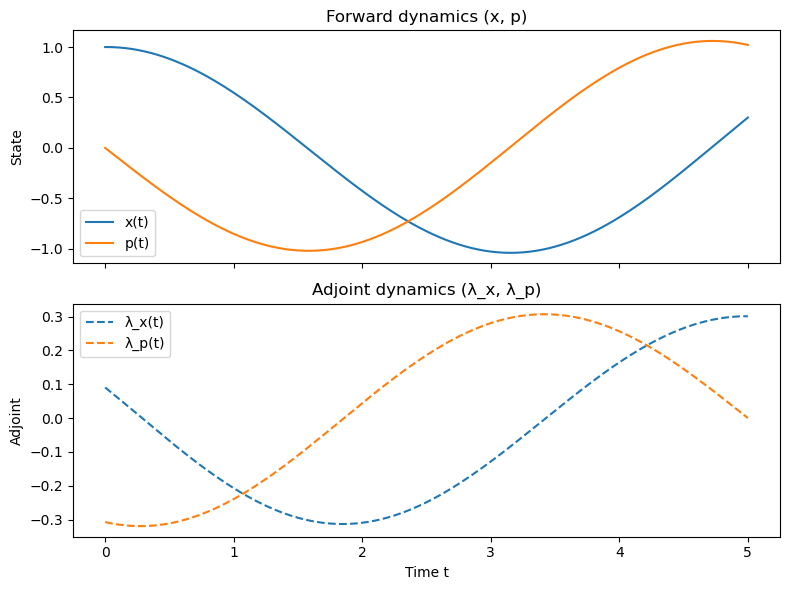

In [3]:
# run forward and adjoint dynamics
ts, xs, ps, λxs, λps = simulate()

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(ts, xs, label='x(t)')
axs[0].plot(ts, ps, label='p(t)')
axs[0].set_ylabel('State')
axs[0].legend()
axs[0].set_title('Forward dynamics (x, p)')

axs[1].plot(ts, λxs, label='λ_x(t)', linestyle='--')
axs[1].plot(ts, λps, label='λ_p(t)', linestyle='--')
axs[1].set_ylabel('Adjoint')
axs[1].set_xlabel('Time t')
axs[1].legend()
axs[1].set_title('Adjoint dynamics (λ_x, λ_p)')

plt.tight_layout()
plt.show()

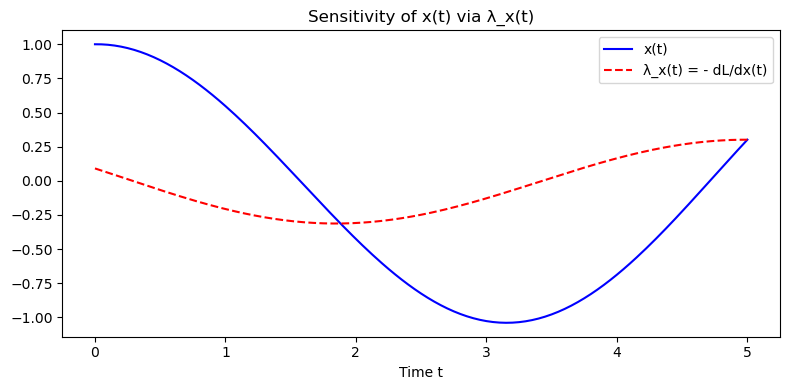

In [4]:
ts, xs, ps, λxs, λps = simulate(x0=1.0)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(ts, xs, label='x(t)', color='blue')
ax.plot(ts, λxs, label='λ_x(t) = - dL/dx(t)', color='red', linestyle='--')
ax.set_title('Sensitivity of x(t) via λ_x(t)')
ax.set_xlabel('Time t')
ax.legend()
plt.tight_layout()
plt.show()


### Verify the gradient

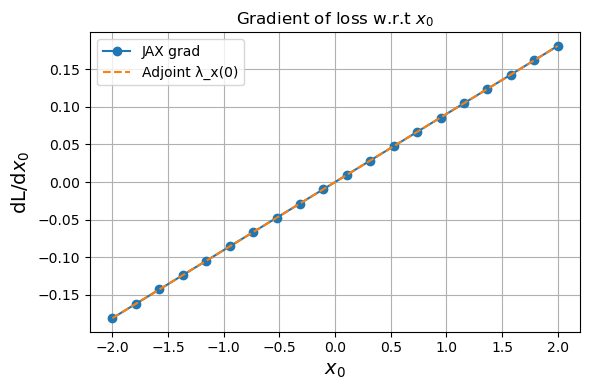

In [5]:
x0s = jnp.linspace(-2, 2, 20)
trajectories = []
losses = []
adjoint_grads = []

for x0 in x0s:
    ts, xs, ps, λxs, λps = simulate(x0=x0)
    trajectories.append(xs)
    losses.append(0.5 * xs[-1]**2)
    adjoint_grads.append(λxs[0])
trajectories = jnp.stack(trajectories)

losses = jnp.array(losses)
adjoint_grads = jnp.array(adjoint_grads)

def loss_fn(x0):
    ts, xs, ps, _, _ = simulate(x0=x0)
    return 0.5 * xs[-1]**2

grad_fn = jax.grad(loss_fn)
autodiff_grads = jnp.array([grad_fn(x0) for x0 in x0s])

# Plot comparison
plt.figure(figsize=(6, 4))
plt.plot(x0s, autodiff_grads, label='JAX grad', marker='o')
plt.plot(x0s, adjoint_grads, label='Adjoint λ_x(0)', linestyle='--')
plt.title('Gradient of loss w.r.t $x_0$')
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('dL/d$x_0$', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Sensitivity analysis

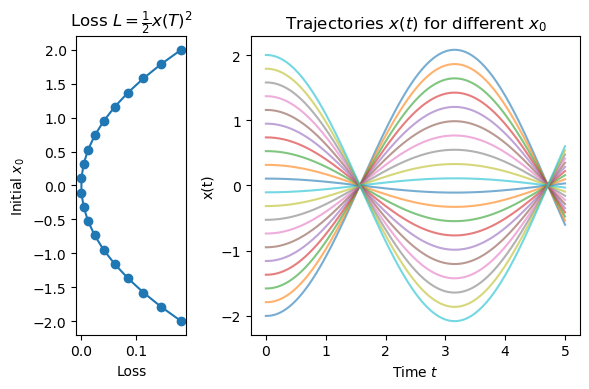

In [6]:
# sweep over initial conditions
x0s = jnp.linspace(-2, 2, 20)
trajectories = []
losses = []
adjoint_grads = []

for x0 in x0s:
    ts, xs, ps, λxs, λps = simulate(x0=x0)
    trajectories.append(xs)
    losses.append(0.5 * xs[-1]**2)
    adjoint_grads.append(λxs[0])

trajectories = jnp.stack(trajectories)
losses = jnp.array(losses)
adjoint_grads = jnp.array(adjoint_grads)

fig = plt.figure(figsize=(6, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 3])

# Left: loss
ax0 = fig.add_subplot(gs[0])
ax0.plot(losses, x0s, marker='o')
ax0.set_title('Loss $L=\\frac{1}{2}x(T)^2$')
ax0.set_ylabel('Initial $x_0$')
ax0.set_xlabel('Loss')

# Right: trajectories
ax1 = fig.add_subplot(gs[1])
for i in range(len(x0s)):
    ax1.plot(ts, trajectories[i], alpha=0.6)
ax1.set_title('Trajectories $x(t)$ for different $x_0$')
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('x(t)')

plt.tight_layout()
plt.show()

### Something more complicated: 5-body problem

In [49]:
T = 2.
dt = 0.04
steps = int(T / dt)

key = jax.random.PRNGKey(0)
N = 4  # number of particles
D = 2  # dimensions

In [50]:
# Newtonian gravity: G = m = 1
def gravity_force(x):
    def pairwise_force(i, x):
        diff = x - x[i]            # (N, D)
        r2 = jnp.sum(diff**2, axis=1) + 1e-5
        r3 = r2 * jnp.sqrt(r2)
        F = jnp.where(jnp.arange(N)[:, None] != i, diff / r3[:, None], 0.0)
        return jnp.sum(F, axis=0)
    
    return jax.vmap(lambda i: pairwise_force(i, x))(jnp.arange(N))

# Forward step: Euler
def forward_step(x, p):
    dx = p
    dp = gravity_force(x)
    return x + dt * dx, p + dt * dp

# Adjoint step: reverse in time
def adjoint_step(x, p, λx, λp):
    # Derivatives of dynamics w.r.t x and p
    def f_x(x_):
        return gravity_force(x_)
    
    # Jacobian-vector products (vjp) using JAX
    _, vjp_fx = jax.vjp(f_x, x)
    dL_dx = vjp_fx(λp)[0]

    λx_new = λx + dt * dL_dx
    λp_new = λp + dt * λx
    return λx_new, λp_new

def loss_fn_x(x_final, x_obs):
    return jnp.sum((x_final - x_obs)**2)

def loss_fn_xp(x_final, p_final, x_obs, p_obs):
    return jnp.sum((x_final - x_obs)**2) + jnp.sum((p_final - p_obs)**2)

# Simulate forward and backward
def simulate(x0, p0, x_obs=None):
    xs, ps = [x0], [p0]

    x, p = x0, p0
    for _ in range(steps):
        x, p = forward_step(x, p)
        xs.append(x)
        ps.append(p)
    
    xs, ps = jnp.stack(xs), jnp.stack(ps)

    if x_obs is None:
        return xs, ps
    
    # loss function
    final_x = xs[-1]
    
    loss = loss_fn_x(final_x, x_obs)

    # Backward pass
    # explicitly derive the gradient with respect to final_x
    λx = 2 * (final_x - x_obs)
    λp = jnp.zeros_like(p)

    λxs, λps = [λx], [λp]
    for t in reversed(range(steps)):
        λx, λp = adjoint_step(xs[t], ps[t], λx, λp)
        λxs.append(λx)
        λps.append(λp)
        
    
    λxs, λps = jnp.stack(λxs[::-1]), jnp.stack(λps[::-1])
    return xs, ps, λxs, λps, loss

### Get a simulation as truth

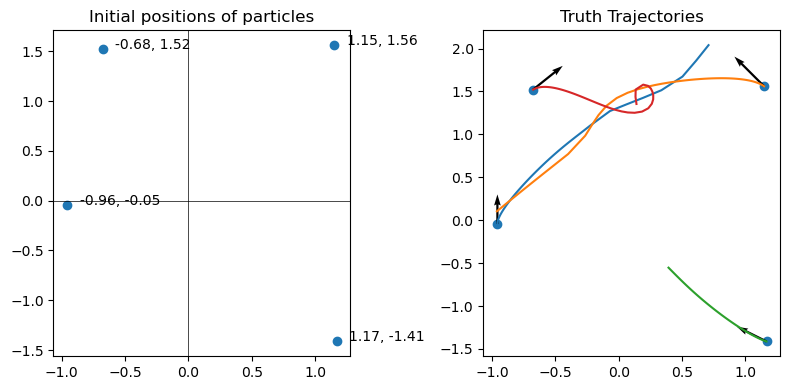

In [97]:


x0 = jnp.array([
    [-1, -1],
    [1, 1],
    [1, -1],
    [-1, 1]
]) + jax.random.normal(key, (4, D)) * 0.5
x0 = jnp.array(x0)
p0 = jnp.array([
    [0, 1],
    [-1, 1],
    [-1, 0.5],
    [1, 0.8]
])*0.2

x_obs, p_obs = simulate(x0, p0, x_obs=None)

f, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(x0[:,0], x0[:,1])
# grid lines
axs[0].axhline(0, color='black', linewidth=0.5)
axs[0].axvline(0, color='black', linewidth=0.5)
axs[0].text(x0[0,0]+0.1, x0[0,1], f'{x0[0,0]:.2f}, {x0[0,1]:.2f}')
axs[0].text(x0[1,0]+0.1, x0[1,1], f'{x0[1,0]:.2f}, {x0[1,1]:.2f}')
axs[0].text(x0[2,0]+0.1, x0[2,1], f'{x0[2,0]:.2f}, {x0[2,1]:.2f}')
axs[0].text(x0[3,0]+0.1, x0[3,1], f'{x0[3,0]:.2f}, {x0[3,1]:.2f}')
axs[0].set_title('Initial positions of particles')

# plot the true trajectory
axs[1].scatter(x0[:,0], x0[:,1])
for i in range(N):
    axs[1].plot(x_obs[:, i, 0], x_obs[:, i, 1], label=f"Particle {i}")
axs[1].quiver(x0[:,0], x0[:,1], p0[:,0], p0[:,1], color='k', scale=2)
axs[1].set_title("Truth Trajectories")
plt.tight_layout()
plt.show()

(51, 4, 2)


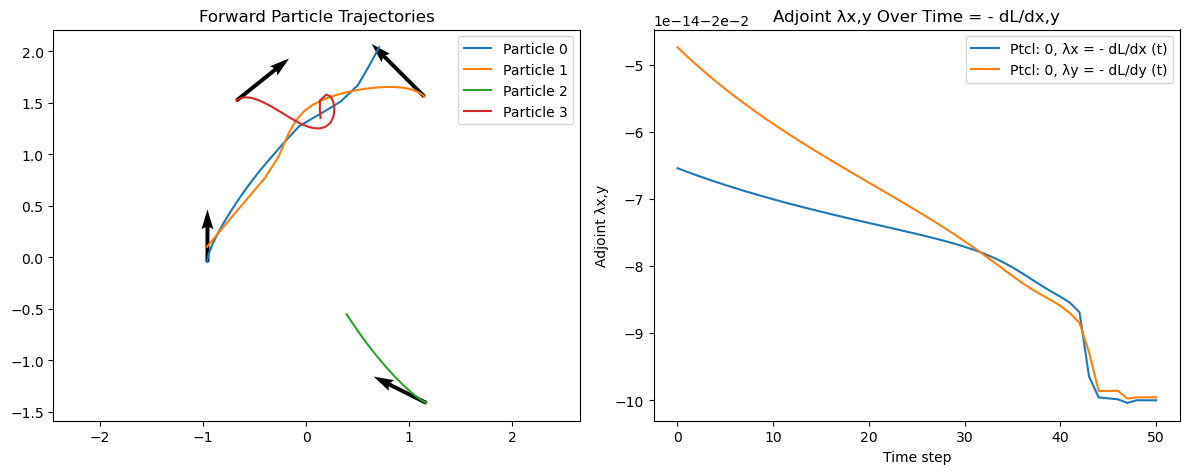

In [98]:
# feed in the truth into the likelihood and visualize the adjoint
def plot_adjoint(x0, p0, x_obs):
    xs, ps, λxs, λps, loss = simulate(x0, p0, x_obs=x_obs[-1]+0.01)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # Left: particle trajectories
    for i in range(N):
        axs[0].plot(xs[:, i, 0], xs[:, i, 1], label=f"Particle {i}")
    axs[0].quiver(x0[:,0], x0[:,1], p0[:,0], p0[:,1], color='k', scale=2)
    axs[0].set_title("Forward Particle Trajectories")
    axs[0].axis("equal")
    axs[0].legend()
    
    # Right: adjoint λx norm over time
    print(λxs.shape) # (T, N, D)
    axs[1].plot(λxs[:, 0, 0], label='Ptcl: 0, λx = - dL/dx (t)')
    axs[1].plot(λxs[:, 0, 1], label='Ptcl: 0, λy = - dL/dy (t)')
    axs[1].set_title("Adjoint λx,y Over Time = - dL/dx,y")
    axs[1].set_xlabel("Time step")
    axs[1].set_ylabel("Adjoint λx,y")
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()  
    
plot_adjoint(x0, p0, x_obs)

/tmp/ipykernel_1922538/3474581775.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbars


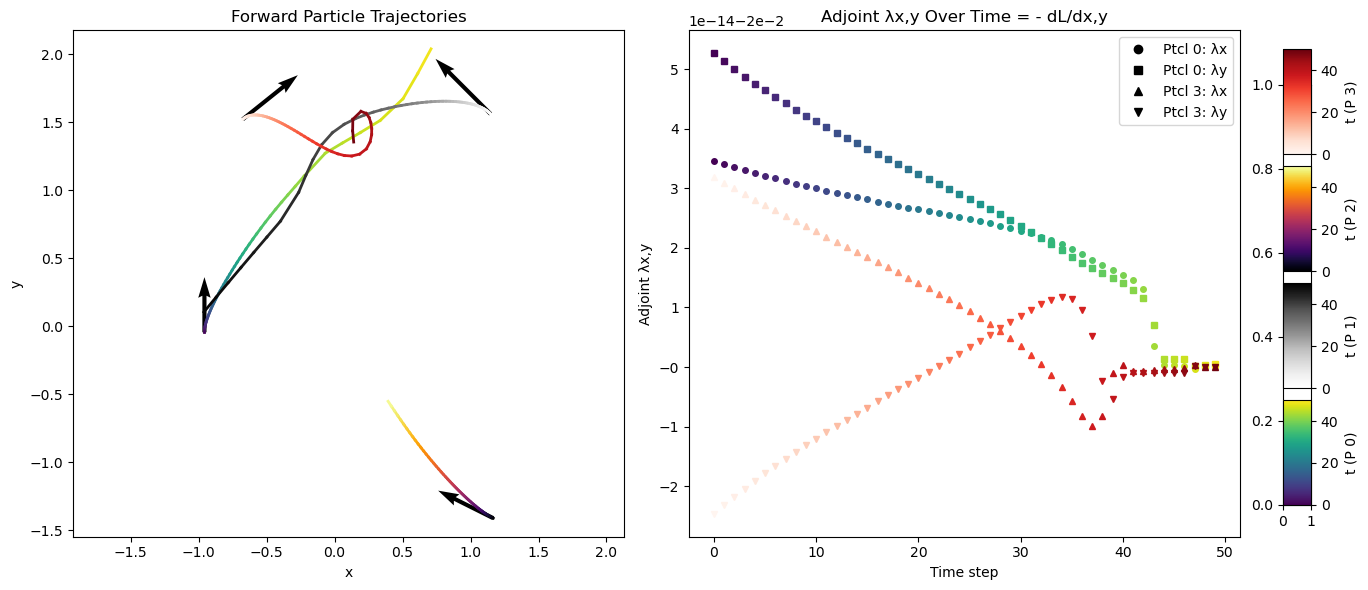

In [88]:
def plot_adjoint(x0, p0, x_obs):
    xs, ps, λxs, λps, loss = simulate(x0, p0, x_obs=x_obs[-1]+0.01)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Create colormap based on time steps
    T = xs.shape[0]
    norm = plt.Normalize(0, T-1)
    cmaps = [plt.cm.viridis, plt.cm.Greys, plt.cm.inferno, plt.cm.Reds]  # One colormap per particle
    
    # Left: particle trajectories with time colormap
    for i in range(N):
        points = xs[:, i, :]
        # Create segments for colored line
        for t in range(T-1):
            segment = axs[0].plot(points[t:t+2, 0], points[t:t+2, 1], 
                               color=cmaps[i](norm(t)), 
                               linewidth=2)
    
    # Add initial momentum vectors
    axs[0].quiver(x0[:,0], x0[:,1], p0[:,0], p0[:,1], color='k', scale=2)
    axs[0].set_title("Forward Particle Trajectories")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    axs[0].axis("equal")
    
    # Right: adjoint λx,y for particles 0 and 3 with different colormaps
    # Particle 0 with viridis colormap
    for t in range(T-1):
        axs[1].plot(t, λxs[t, 0, 0], 'o', color=cmaps[0](norm(t)), markersize=4)
        axs[1].plot(t, λxs[t, 0, 1], 's', color=cmaps[0](norm(t)), markersize=4)
    
    # Particle 3 with plasma colormap
    for t in range(T-1):
        axs[1].plot(t, λxs[t, 3, 0], '^', color=cmaps[3](norm(t)), markersize=4)
        axs[1].plot(t, λxs[t, 3, 1], 'v', color=cmaps[3](norm(t)), markersize=4)
    
    axs[1].plot([], [], 'o', color='black', label='Ptcl 0: λx')
    axs[1].plot([], [], 's', color='black', label='Ptcl 0: λy')
    axs[1].plot([], [], '^', color='black', label='Ptcl 3: λx')
    axs[1].plot([], [], 'v', color='black', label='Ptcl 3: λy')
    axs[1].set_title("Adjoint λx,y Over Time = - dL/dx,y")
    axs[1].set_xlabel("Time step")
    axs[1].set_ylabel("Adjoint λx,y")
    axs[1].legend()
    
    # Add vertical colorbars for each particle to the right of the second plot
    # Create placeholder for colorbars
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    
    # Calculate height for each colorbar
    cbar_height = 0.7 / N
    cbar_margin = 0.02
    
    # Add one colorbar per particle
    for i in range(N):
        y_pos = 0.15 + i * (cbar_height + cbar_margin)
        cbar_ax_i = fig.add_axes([0.92, y_pos, 0.02, cbar_height])
        sm = plt.cm.ScalarMappable(cmap=cmaps[i], norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax_i)
        cbar.set_label(f't (P {i})')
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbars
    plt.show()
    
plot_adjoint(x0, p0, x_obs)

## Optimization

### Initialzing a guess

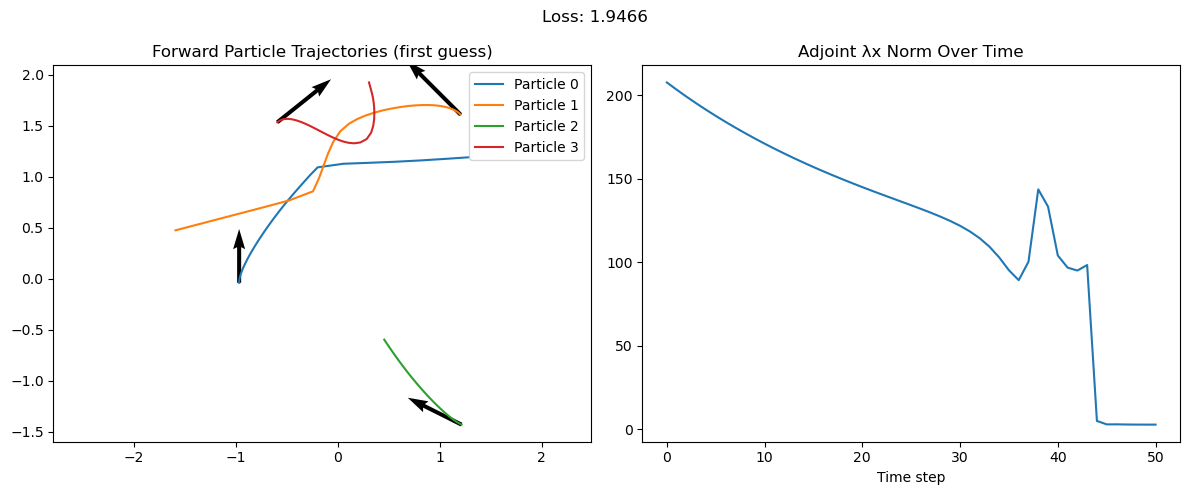

In [132]:
key = jax.random.PRNGKey(8)
noise_level = 0.05
x0_guess = x0 + jax.random.normal(key, (4, D)) * noise_level
x0_guess = jnp.array(x0_guess)

xs, ps, λxs, λps, loss = simulate(x0_guess, p0, x_obs=x_obs[-1])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Left: particle trajectories
for i in range(N):
    axs[0].plot(xs[:, i, 0], xs[:, i, 1], label=f"Particle {i}")
axs[0].quiver(x0_guess[:,0], x0_guess[:,1], p0[:,0], p0[:,1], color='k', scale=2)
axs[0].set_title("Forward Particle Trajectories (first guess)")
axs[0].axis("equal")
axs[0].legend()

# Right: λx norm over time
axs[1].plot(jnp.linalg.norm(λxs, axis=(1,2)))
axs[1].set_title("Adjoint λx Norm Over Time")
axs[1].set_xlabel("Time step")
plt.suptitle(f"Loss: {loss:.4f}")
plt.tight_layout()
plt.show()

In [133]:
import optax

# Adam optimizer setup
lr = 0.02
opt = optax.adam(lr)
x0_init = x0_guess
opt_state = opt.init(x0_init)

# Store x0 estimate history
x0_history = [x0_init]
loss_history = []

x0_maxlike = x0_init

# Define optimization loop
@jax.jit
def step(x0, opt_state):
    def loss_and_states(x0_):
        xs, ps, λxs, λps, loss = simulate(x0_, p0, x_obs=x_obs[-1])
        return loss, (xs, λxs)

    (loss, (xs, λxs)), grad = jax.value_and_grad(loss_and_states, has_aux=True)(x0)
    updates, opt_state = opt.update(grad, opt_state)
    x0 = optax.apply_updates(x0, updates)
    return x0, opt_state, loss, xs, λxs

traj_history = []
adjoint_history = []

for i in range(150):
    x0_maxlike, opt_state, loss, xs, λxs = step(x0_maxlike, opt_state)
    x0_history.append(x0_maxlike)
    loss_history.append(loss)
    traj_history.append(xs)
    adjoint_history.append(λxs)

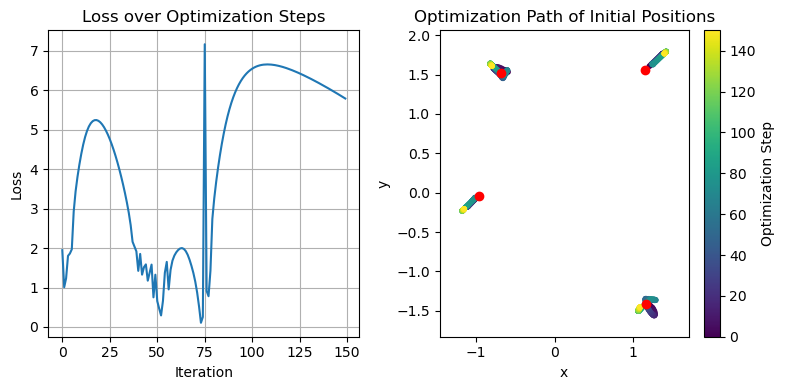

In [134]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import jax.numpy as jnp

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot 1: Loss curve
ax1.plot(loss_history)
ax1.set_title("Loss over Optimization Steps")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot 2: Optimization path with color gradient
x0_hist_arr = jnp.stack(x0_history)
n_steps = len(x0_history)

# Create a normalized colormap that both plots can use
norm = Normalize(vmin=0, vmax=n_steps-1)

# Plot trajectories with color gradient
for i in range(4):
    points = x0_hist_arr[:, i, :]
    scatter = ax2.scatter(points[:, 0], points[:, 1], 
                         c=jnp.arange(n_steps), 
                         cmap='viridis',
                         s=10,
                         norm=norm)  # Use the normalized colormap

# Plot initial positions
for i in range(4):
    ax2.scatter(x0[i, 0], x0[i, 1], marker='o', color='red')
    
ax2.set_title("Optimization Path of Initial Positions")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.axis("equal")
cbar = fig.colorbar(scatter, ax=ax2, label='Optimization Step')

plt.tight_layout()
plt.savefig(f'/hildafs/projects/phy230056p/junzhez/adjoint-demo/notebook/noise_{noise_level}_lr_{lr}.png')
plt.show()

# more visualization

In [135]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

def make_movie(traj_history, adjoint_history, traj_truth, filename='/hildafs/projects/phy230056p/junzhez/adjoint-demo/notebook/adjoint_trajectory.gif', interval=100):
    fig, ax = plt.subplots(figsize=(6, 6))

    scat_traj = ax.plot([], [], 'o-', color='blue', label='Trajectory')[0]
    scat_adj = ax.quiver([], [], [], [], color='red', angles='xy', scale_units='xy', scale=1, width=0.003)

    def init():
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_title('Optimization Step: 0')
        ax.legend()
        return scat_traj, scat_adj

    def update(frame):
        xs = np.array(traj_history[frame])  # (T, N, D)
        λs = np.array(adjoint_history[frame])  # (T, N, D)

        T = xs.shape[0]
        N = xs.shape[1]

        ax.clear()
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_title(f'Optimization Step: {frame}')
        
        for i in range(N):
            # Plot trajectory of particle i
            ax.plot(xs[:, i, 0], xs[:, i, 1], '-', label=f'Particle {i}' if frame == 0 else "")
            # Plot arrows for λx at each time step
            # ax.quiver(xs[:, i, 0], xs[:, i, 1], λs[:, i, 0], λs[:, i, 1], color='red', scale=5)

            # plot the truth trajectory
            ax.plot(traj_truth[:, i, 0], traj_truth[:, i, 1], 'k--', label='Truth Trajectory')
        return scat_traj, scat_adj

    ani = FuncAnimation(fig, update, frames=len(traj_history), init_func=init, blit=False, interval=interval)
    ani.save(filename, writer='pillow')
    plt.close()
    
# make_movie(traj_history, adjoint_history, x_obs)

In [136]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from matplotlib.colors import Normalize

def make_movie_adj(traj_history, adjoint_history, traj_truth, filename='/hildafs/projects/phy230056p/junzhez/adjoint-demo/notebook/adjoint_trajectory_adj.gif', interval=100):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Define colormaps for each particle
    cmaps = ['Greys', 'Reds', 'Blues', 'Greens']
    
    def init():
        ax1.set_xlim(-2, 2)
        ax1.set_ylim(-2, 2)
        ax1.set_title('Particle Trajectories')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        
        ax2.set_title('Particle 0 Adjoint Values')
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Adjoint Value')
        return []

    def update(frame):
        ax1.clear()
        ax2.clear()
        
        # Set titles and limits
        ax1.set_xlim(-2, 2)
        ax1.set_ylim(-2, 2)
        ax1.set_title(f'Particle Trajectories (Step {frame})')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        
        ax2.set_title(f'Particle 0 Adjoint Values (Step {frame})')
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Adjoint Value')
        
        xs = np.array(traj_history[frame])  # (T, N, D)
        λs = np.array(adjoint_history[frame])  # (T, N, D)
        
        T = xs.shape[0]
        N = xs.shape[1]
        
        # Create color gradients for time
        norm = Normalize(0, T-1)
        
        # Plot trajectories using separate colormaps for each particle
        for i in range(N):
            # Create color map for this particle
            cmap = plt.cm.get_cmap(cmaps[i])
            
            # Plot trajectory with time color gradient
            for t in range(T-1):
                ax1.plot(xs[t:t+2, i, 0], xs[t:t+2, i, 1], '-', 
                        color=cmap(norm(t)), 
                        linewidth=2)
            
            # Plot truth trajectory
            ax1.plot(traj_truth[:, i, 0], traj_truth[:, i, 1], '--', 
                    color=cmap(0.7), 
                    linewidth=1,
                    alpha=0.5,
                    label=f'Truth {i}')
        
        # Right subplot: adjoint values for particle 0
        cmap0 = plt.cm.get_cmap(cmaps[0])
        
        # Plot λx with time color gradient
        for t in range(T):
            ax2.plot(t, λs[t, 0, 0], 'o', color=cmap0(norm(t)), markersize=6)
            ax2.plot(t, λs[t, 0, 1], 's', color=cmap0(norm(t)), markersize=6)
        
        # Add legend to the right plot
        ax2.plot([], [], 'o', color='black', label='λx')
        ax2.plot([], [], 's', color='black', label='λy')
        ax2.legend()
        
        # Add legends to the trajectory plot
        for i in range(N):
            ax1.plot([], [], '-', color=plt.cm.get_cmap(cmaps[i])(0.5), label=f'Particle {i}')
        ax1.legend(loc='upper left')
        
        return []

    ani = FuncAnimation(fig, update, frames=len(traj_history), init_func=init, blit=False, interval=interval)
    ani.save(filename, writer='pillow')
    plt.close()
    
    return f"Animation saved to {filename}"
    
# Call the function
# make_movie_adj(traj_history, adjoint_history, x_obs)

### make movies

In [137]:
model_name = f'noise_{noise_level}_lr_{lr}'
filename = f'/hildafs/projects/phy230056p/junzhez/adjoint-demo/notebook/{model_name}.gif'
make_movie_adj(traj_history, adjoint_history, x_obs, filename=filename)

/tmp/ipykernel_1922538/2835645556.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmaps[i])
/tmp/ipykernel_1922538/2835645556.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap0 = plt.cm.get_cmap(cmaps[0])
/tmp/ipykernel_1922538/2835645556.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax1.plot([], [], '-', color=plt.cm.get_cmap(cmaps[i])(0.5), label=f'Particle {i}')


'Animation saved to /hildafs/projects/phy230056p/junzhez/adjoint-demo/notebook/noise_0.05_lr_0.02.gif'